# Projet de tarification automobile
## Présentation   

Ce projet vise à **modéliser la fréquence et le coût moyen des sinistres** à l’aide de trois modèles de machine learning : **Random Forest Regressor, Gradient Boosting Regressor et HistGradientBoosting Regressor**.

Les données, issues du **package** CASdatasets, permettent d’analyser séparément la **fréquence des sinistres** (nombre de sinistres par contrat) et leur **coût moyen**. La fréquence présente une distribution relativement stable, tandis que le coût moyen est très dispersé et asymétrique, en raison de **sinistres exceptionnellement élevés**.

Ces valeurs extrêmes influencent fortement les indicateurs de performance (comme le **MSE**) et peuvent conduire à un **R² négatif**, traduisant la difficulté du modèle à prédire correctement les sinistres rares mais coûteux.

Pour améliorer la précision, nous proposons une **segmentation des variables quantitatives et qualitatives** en trois catégories de risque — **petit, moyen et grand risque** — afin de constituer trois sous-bases de données distinctes. Sur chacune d’elles, la **prime pure** est ensuite recalculée (sous R).

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt  # aussi nécessaire pour plt
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

In [96]:
# Exemple pour un CSV avec point-virgule comme séparateur
df_freq = pd.read_csv('C:/Users/liang/Desktop/Actuariat/ChatGDP/Tarification/ess/Tarification_base_freq.csv', sep=';')
df_freq.info()
print(df_freq.head())
df_freq.describe()
print(df_freq.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413169 entries, 0 to 413168
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   PolicyID   413169 non-null  int64  
 1   ClaimNb    413169 non-null  int64  
 2   Exposure   413169 non-null  float64
 3   Power      413169 non-null  object 
 4   CarAge     413169 non-null  int64  
 5   DriverAge  413169 non-null  int64  
 6   Brand      413169 non-null  object 
 7   Gas        413169 non-null  object 
 8   Region     413169 non-null  object 
 9   Density    413169 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 31.5+ MB
   PolicyID  ClaimNb  Exposure Power  CarAge  DriverAge  \
0         1        0      0.09     g       0         46   
1         2        0      0.84     g       0         46   
2         3        0      0.52     f       2         38   
3         4        0      0.45     f       2         38   
4         5        0      0.15     g   

             CarAge  DriverAge   Density
CarAge     1.000000  -0.046414 -0.142318
DriverAge -0.046414   1.000000 -0.001692
Density   -0.142318  -0.001692  1.000000


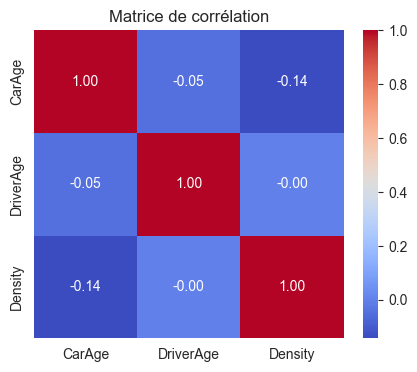

In [97]:
# Corrélation pour des variables quantitatives
df_corr = df_freq[['CarAge', 'DriverAge', 'Density']]
corr_matrix = df_corr.corr()
print(corr_matrix)
plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

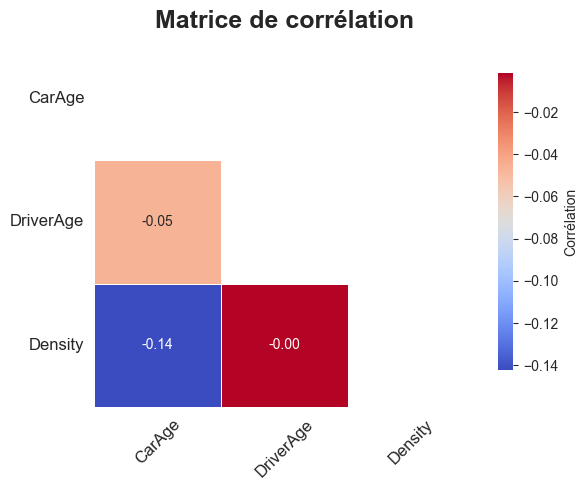

In [98]:
# Créer le masque pour la moitié supérieure
mask = np.triu(corr_matrix)

# Créer la heatmap jolie
plt.figure(figsize=(6,5))
sns.set_style("white")  # fond blanc

sns.heatmap(
    corr_matrix, 
    annot=True,            # afficher les coefficients
    fmt=".2f",             # 2 décimales
    cmap='coolwarm',       # palette de couleurs
    linewidths=0.5,        # lignes entre les cases
    linecolor='white',
    mask=mask,             # appliquer le masque
    cbar_kws={"shrink": .8, "label": "Corrélation"}  # légende
)

plt.title("Matrice de corrélation", fontsize=18, weight='bold')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()

In [99]:
counts = df_freq['PolicyID'].value_counts()
print(counts)
# Compter les occurrences de chaque valeur
counts = df_freq['PolicyID'].value_counts()

# Sélectionner seulement celles qui apparaissent plus d'une fois
more_than_one = counts[counts > 1]
print(more_than_one)

PolicyID
413169    1
1         1
2         1
3         1
4         1
         ..
21        1
22        1
23        1
24        1
25        1
Name: count, Length: 413169, dtype: int64
Series([], Name: count, dtype: int64)


In [100]:
more_than_one = counts[counts > 1]
print(more_than_one)

Series([], Name: count, dtype: int64)


In [101]:
# Compter les occurrences de chaque valeur
counts_freq = df_freq['PolicyID'].value_counts()

# Parcourir uniquement celles qui apparaissent plus d'une fois
for value, count_freq in counts_freq.items():
    if count_freq > 1:
        print(f"{value} apparaît {count_freq} fois")

**Conclusion:** tous les "PolicyID" présente **juste une fois** dans la base df_freq   
## Calcul la fréquence par "PolicyID"

In [102]:
df_freq['Fréquence'] = df_freq['ClaimNb'] / df_freq['Exposure']

# Affichage de la fréquence par police
print("Fréquence par PolicyID :")
print(df_freq)

Fréquence par PolicyID :
        PolicyID  ClaimNb  Exposure Power  CarAge  DriverAge  \
0              1        0  0.090000     g       0         46   
1              2        0  0.840000     g       0         46   
2              3        0  0.520000     f       2         38   
3              4        0  0.450000     f       2         38   
4              5        0  0.150000     g       0         41   
...          ...      ...       ...   ...     ...        ...   
413164    413165        0  0.002740     j       0         29   
413165    413166        0  0.005479     d       0         29   
413166    413167        0  0.005479     k       0         49   
413167    413168        0  0.002740     d       0         41   
413168    413169        0  0.002740     g       6         29   

                                     Brand      Gas              Region  \
0       Japanese (except Nissan) or Korean   Diesel           Aquitaine   
1       Japanese (except Nissan) or Korean   Diesel     

In [103]:
# Base de données "ClaimAmount"
df_cout = pd.read_csv('C:/Users/liang/Desktop/Actuariat/ChatGDP/Tarification/ess/Tarification_base_CM.csv', sep=';')
print(df_cout.head())
df_cout.info()

   PolicyID  ClaimAmount
0     63987         1172
1    310037         1905
2    314463          115
3    318713          122
4    309380        55077
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16181 entries, 0 to 16180
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PolicyID     16181 non-null  int64
 1   ClaimAmount  16181 non-null  int64
dtypes: int64(2)
memory usage: 253.0 KB


In [104]:
# Compter les occurrences de chaque valeur
counts = df_cout['PolicyID'].value_counts()

# Parcourir uniquement celles qui apparaissent plus d'une fois
for value, count in counts.items():
    if count > 1:
        print(f"{value} apparaît {count} fois")

311457 apparaît 4 fois
226856 apparaît 4 fois
18652 apparaît 4 fois
43381 apparaît 3 fois
27390 apparaît 3 fois
25580 apparaît 3 fois
310634 apparaît 3 fois
155019 apparaît 3 fois
25363 apparaît 3 fois
15608 apparaît 3 fois
235734 apparaît 3 fois
136483 apparaît 3 fois
225972 apparaît 3 fois
321161 apparaît 3 fois
96558 apparaît 3 fois
392716 apparaît 3 fois
315349 apparaît 3 fois
100019 apparaît 3 fois
95753 apparaît 3 fois
83747 apparaît 3 fois
137318 apparaît 3 fois
400640 apparaît 3 fois
164029 apparaît 3 fois
292086 apparaît 3 fois
373916 apparaît 3 fois
343710 apparaît 3 fois
34916 apparaît 3 fois
330222 apparaît 3 fois
130753 apparaît 3 fois
209429 apparaît 3 fois
309380 apparaît 3 fois
24878 apparaît 2 fois
378023 apparaît 2 fois
319926 apparaît 2 fois
404165 apparaît 2 fois
227935 apparaît 2 fois
382215 apparaît 2 fois
52452 apparaît 2 fois
165548 apparaît 2 fois
40219 apparaît 2 fois
384140 apparaît 2 fois
134746 apparaît 2 fois
163687 apparaît 2 fois
13091 apparaît 2 fois
13

Il existe des "PolicyID" qui présentent **plusieur fois**     
### pour la même 'PolicyID', on calcul la somme de 'ClaimAmount' et compter "le nombre d'exposition"

In [14]:
# 1) Créer une colonne avec le nombre d'occurrences de chaque PolicyID
df_cout['Policy_Count'] = df_cout['PolicyID'].map(df_cout['PolicyID'].value_counts())
# 2) Créer une colonne avec la somme totale de ClaimAmount par PolicyID
df_cout['Total_Claim'] = df_cout.groupby('PolicyID')['ClaimAmount'].transform('sum')
df_cout[df_cout['Policy_Count'] > 1]

,PolicyID,ClaimAmount,Policy_Count,Total_Claim
4,309380,55077,3,62793
5,309380,7593,3,62793
23,309894,1182,2,2444
26,319926,285,2,840
27,319926,555,2,840
...,...,...,...,...
16118,208591,488,2,911
16119,217050,676,2,744
16139,215642,244,2,6432
16172,304172,281,2,857


In [29]:
# 1) Créer une colonne avec le nombre d'occurrences de chaque PolicyID
df_cout['Policy_Count'] = df_cout['PolicyID'].map(df_cout['PolicyID'].value_counts())

# 2) Créer une colonne avec la somme totale de ClaimAmount par PolicyID
df_cout['Total_Claim'] = df_cout.groupby('PolicyID')['ClaimAmount'].transform('sum')

# 3) (Optionnel) Filtrer uniquement les PolicyID apparaissant plus d’une fois
df_repetes = df_cout[df_cout['Policy_Count'] >= 1]

# example: 
print(df_repetes)
a = df_cout[df_cout['PolicyID'] == 309380]
a
print(a)
b = df_cout[df_cout['PolicyID'] == 309894]
b

       PolicyID  ClaimAmount  Policy_Count  Total_Claim
0         63987         1172             1         1172
1        310037         1905             1         1905
2        314463          115             1          115
3        318713          122             1          122
4        309380        55077             3        62793
...         ...          ...           ...          ...
16176    302759           61             1           61
16177    299443         1831             1         1831
16178    303389         4183             1         4183
16179    304313          566             1          566
16180    206241         2156             1         2156

[16181 rows x 4 columns]
      PolicyID  ClaimAmount  Policy_Count  Total_Claim
4       309380        55077             3        62793
5       309380         7593             3        62793
2009    309380          123             3        62793


,PolicyID,ClaimAmount,Policy_Count,Total_Claim
23,309894,1182,2,2444
83,309894,1262,2,2444


#### Garder une seule ligne par PolicyID, en choisissant celle où Policy_Count est maximale.

In [32]:
# Trier par PolicyID et Policy_Count décroissant
df_cout_sorted = df_cout.sort_values(['PolicyID', 'Policy_Count'], ascending=[True, False])

# Garder seulement la première ligne de chaque PolicyID
df_cout_unique = df_cout_sorted.drop_duplicates(subset='PolicyID', keep='first')
df_cout_unique

,PolicyID,ClaimAmount,Policy_Count,Total_Claim
1429,33,302,1,302
1363,41,2001,1,2001
643,92,1449,1,1449
341,96,946,2,10870
1604,142,139,1,139
...,...,...,...,...
1245,412262,1426,1,1426
1243,412270,1364,1,1364
1241,412664,7603,1,7603
1275,412926,1751,1,1751


#### Chaque observation présent juste une fois

In [34]:
# Compter les occurrences de chaque valeur
counts = df_cout_unique['PolicyID'].value_counts()

# Parcourir uniquement celles qui apparaissent plus d'une fois
for value, count in counts.items():
    if count > 1:
        print(f"{value} apparaît {count} fois")

Conclusion: tous les "PolicyID" dans la base "df_somme_claim" **présente juste une fois** dans la base df_somme_claim    

### Combiner ces deux base de données ('PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas', 'Region', 'Density', 'ClaimAmount', 'Policy_Count','Total_Claim')

In [35]:
df_CM = pd.merge(df_freq, df_cout_unique, on='PolicyID', how='right')
df_CM.info()
df_CM.head()
print(df_CM.columns)
print(df_CM.head())
df_CM.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15390 entries, 0 to 15389
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PolicyID      15390 non-null  int64  
 1   ClaimNb       15390 non-null  int64  
 2   Exposure      15390 non-null  float64
 3   Power         15390 non-null  object 
 4   CarAge        15390 non-null  int64  
 5   DriverAge     15390 non-null  int64  
 6   Brand         15390 non-null  object 
 7   Gas           15390 non-null  object 
 8   Region        15390 non-null  object 
 9   Density       15390 non-null  int64  
 10  Fréquence     15390 non-null  float64
 11  ClaimAmount   15390 non-null  int64  
 12  Policy_Count  15390 non-null  int64  
 13  Total_Claim   15390 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 1.6+ MB
Index(['PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge',
       'Brand', 'Gas', 'Region', 'Density', 'Fréquence', 'ClaimAmou

,PolicyID,ClaimNb,Exposure,CarAge,DriverAge,Density,Fréquence,ClaimAmount,Policy_Count,Total_Claim
count,15390.000000,15390.000000,15390.000000,15390.000000,15390.000000,15390.000000,15390.000000,1.539000e+04,15390.000000,1.539000e+04
mean,184230.288044,1.051397,0.707456,7.700715,44.905718,2061.834698,3.189466,1.905209e+03,1.051397,1.987512e+03
std,117719.719467,0.231446,0.313214,5.245196,14.850244,4910.902468,10.719636,1.829859e+04,0.231446,1.834936e+04
min,33.000000,1.000000,0.002740,0.000000,18.000000,2.000000,0.666667,1.000000e+00,1.000000,1.000000e+00
25%,82998.250000,1.000000,0.460000,3.000000,33.000000,82.000000,1.000000,4.490000e+02,1.000000,5.012500e+02
50%,169537.000000,1.000000,0.800000,7.000000,44.000000,364.000000,1.315789,1.138000e+03,1.000000,1.145000e+03
75%,280502.000000,1.000000,1.000000,11.000000,54.000000,1445.000000,2.325581,1.227000e+03,1.000000,1.245000e+03
max,412944.000000,4.000000,1.500000,99.000000,99.000000,27000.000000,365.000000,2.036833e+06,4.000000,2.036833e+06


In [36]:
# Compter les occurrences de chaque valeur
counts = df_CM['PolicyID'].value_counts()

# Parcourir uniquement celles qui apparaissent plus d'une fois
for value, count in counts.items():
    if count > 1:
        print(f"{value} apparaît {count} fois")

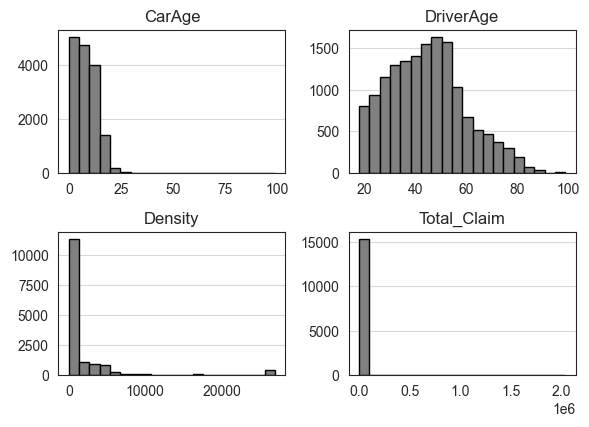

In [37]:
colonnes = ['CarAge', 'DriverAge', 'Density','Total_Claim'] 
        
# Créer la figure avec 7 subplots (2 colonnes x 4 lignes, la dernière sera vide)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(6,8))
axes = axes.flatten()  # transformer en liste pour faciliter l'indexation

for i, col in enumerate(colonnes):
    axes[i].hist(df_CM[col], bins=20, color='grey', edgecolor='black')
    axes[i].set_title(col, fontsize=12)
    axes[i].grid(axis='y', alpha=0.75)

# Supprimer le dernier subplot vide si colonnes < nombre de subplots
if len(colonnes) < len(axes):
    for j in range(len(colonnes), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

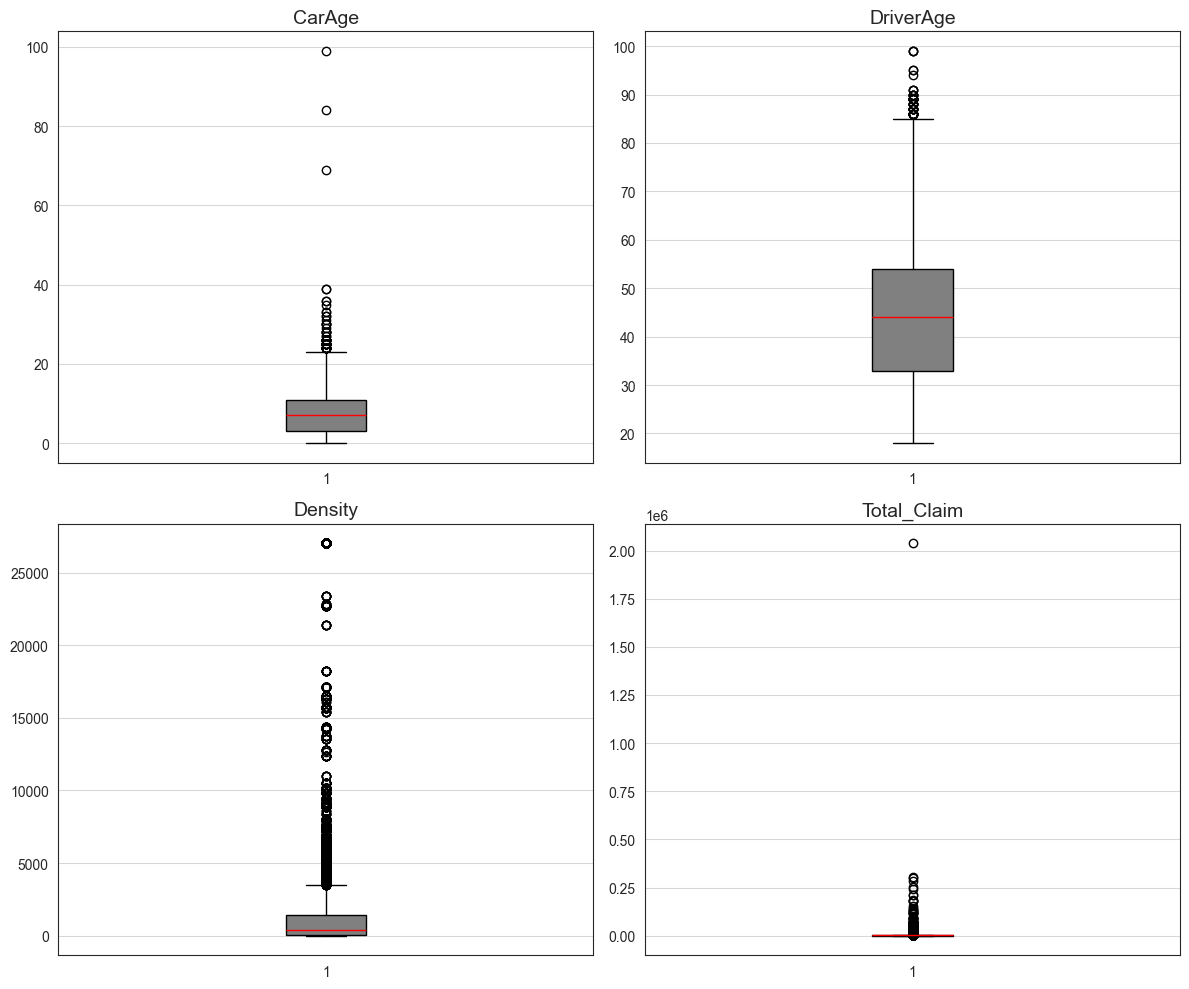

In [38]:
colonnes = ['CarAge', 'DriverAge', 'Density','Total_Claim'] 
# Créer 4 subplots (2 lignes x 2 colonnes)
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()  # transformer en liste pour itérer

# Boucle sur chaque colonne
for i, col in enumerate(colonnes):
    axes[i].boxplot(df_CM[col], patch_artist=True,
                    boxprops=dict(facecolor='grey', color='black'),
                    medianprops=dict(color='red'))
    axes[i].set_title(col, fontsize=14)
    axes[i].grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

In [39]:
df = df_CM
print(df_CM.columns)

Index(['PolicyID', 'ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge',
       'Brand', 'Gas', 'Region', 'Density', 'Fréquence', 'ClaimAmount',
       'Policy_Count', 'Total_Claim'],
      dtype='object')


In [41]:
print(df[['Power','Brand','Gas','Region']].head())
print(df[['Power','Brand','Gas','Region']].isnull().sum())
print(df[['Power','Brand','Gas','Region']].apply(lambda x: x.unique()))

  Power                               Brand      Gas              Region
0     g  Japanese (except Nissan) or Korean  Regular       Ile-de-France
1     l  Japanese (except Nissan) or Korean   Diesel     Basse-Normandie
2     d  Japanese (except Nissan) or Korean  Regular       Ile-de-France
3     j  Japanese (except Nissan) or Korean  Regular       Ile-de-France
4     e  Japanese (except Nissan) or Korean  Regular  Nord-Pas-de-Calais
Power     0
Brand     0
Gas       0
Region    0
dtype: int64
Power                  [g, l, d, j, e, i, f, h, k, o, n, m]
Brand     [Japanese (except Nissan) or Korean, Renault, ...
Gas                                       [Regular, Diesel]
Region    [Ile-de-France, Basse-Normandie, Nord-Pas-de-C...
dtype: object


In [43]:
df[['Power','Brand','Gas','Region']] = df[['Power','Brand','Gas','Region']].fillna('Unknown')

# Tarification par régression ou modèle actuariel basé sur les données    
Machine Learning / Pipeline avec One-Hot Encoding   
Ce que nous avons essayé avec Pipeline, ColumnTransformer et LinearRegression.    
C’est une approche data-driven, compatible avec des modèles plus complexes comme les forêts aléatoires ou XGBoost.

In [44]:
quant_features = ['CarAge', 'DriverAge', 'Density']
qual_features = ['Power','Brand', 'Gas', 'Region']

    
X = df[quant_features + qual_features]
y = df['Total_Claim']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', quant_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), qual_features)

    ]
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraîner le modèle sur X et y
model.fit(X, y)

# Prédiction
df['Predicted_Total_Claim'] = model.predict(X)
print(df[['PolicyID','Total_Claim','Predicted_Total_Claim']])


       PolicyID  Total_Claim  Predicted_Total_Claim
0            33          302            1221.860586
1            41         2001            2056.168599
2            92         1449            2060.015882
3            96        10870            1548.463132
4           142          139            1936.780544
...         ...          ...                    ...
15385    412262         1426            1434.702939
15386    412270         1364            1474.411893
15387    412664         7603            2096.980155
15388    412926         1751            1838.043189
15389    412944        12491            1720.855027

[15390 rows x 3 columns]


In [45]:
print(df_CM.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15390 entries, 0 to 15389
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PolicyID               15390 non-null  int64  
 1   ClaimNb                15390 non-null  int64  
 2   Exposure               15390 non-null  float64
 3   Power                  15390 non-null  object 
 4   CarAge                 15390 non-null  int64  
 5   DriverAge              15390 non-null  int64  
 6   Brand                  15390 non-null  object 
 7   Gas                    15390 non-null  object 
 8   Region                 15390 non-null  object 
 9   Density                15390 non-null  int64  
 10  Fréquence              15390 non-null  float64
 11  ClaimAmount            15390 non-null  int64  
 12  Policy_Count           15390 non-null  int64  
 13  Total_Claim            15390 non-null  int64  
 14  Predicted_Total_Claim  15390 non-null  float64
dtypes:

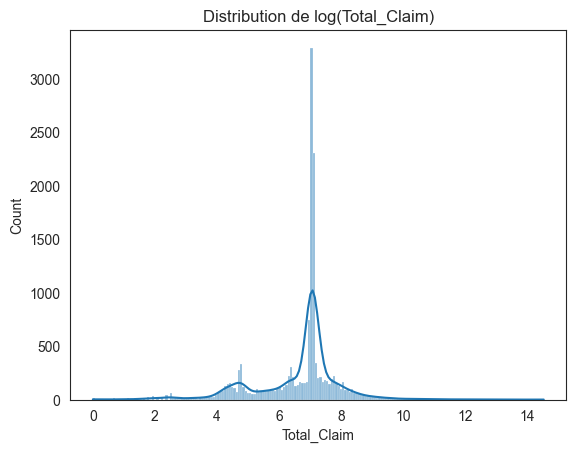

In [46]:
sns.histplot(np.log(df['Total_Claim']), kde=True)
plt.title("Distribution de log(Total_Claim)")
plt.show()

In [47]:
data = df['Total_Claim'].dropna()

# Ajuster une loi Gamma
params_gamma = st.gamma.fit(data)
ks_gamma = st.kstest(data, 'gamma', params_gamma)

# Ajuster une loi lognormale
params_lognorm = st.lognorm.fit(data)
ks_lognorm = st.kstest(data, 'lognorm', params_lognorm)

print("KS Gamma:", ks_gamma)
print("KS Lognorm:", ks_lognorm)


KS Gamma: KstestResult(statistic=np.float64(0.999932687421717), pvalue=np.float64(0.0), statistic_location=np.int64(1), statistic_sign=np.int8(-1))
KS Lognorm: KstestResult(statistic=np.float64(0.2054538310307984), pvalue=np.float64(0.0), statistic_location=np.int64(1061), statistic_sign=np.int8(-1))


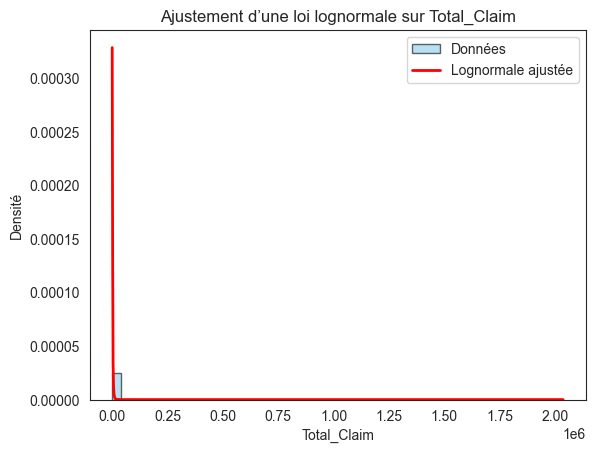

In [49]:
# Données
data = df['Total_Claim'].dropna()

# Ajuster une loi lognormale
shape, loc, scale = st.lognorm.fit(data)

# Créer un histogramme normalisé
plt.hist(data, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Données')

# Créer un espace x pour la courbe théorique
x = np.linspace(data.min(), data.max(), 1000)
pdf = st.lognorm.pdf(x, shape, loc, scale)

# Tracer la courbe lognormale ajustée
plt.plot(x, pdf, 'r', lw=2, label='Lognormale ajustée')

plt.xlabel('Total_Claim')
plt.ylabel('Densité')
plt.title('Ajustement d’une loi lognormale sur Total_Claim')
plt.legend()
plt.show()

***Interprétation*** :

statistic : distance maximale entre la distribution empirique de tes données et la distribution théorique.

Plus cette valeur est petite, mieux la loi théorique correspond à tes données.

0.9999 pour Gamma → énorme différence, donc Gamma n’est pas un bon ajustement.

0.2054 pour Lognorm → beaucoup plus faible, donc Lognormale s’ajuste mieux que Gamma, même si ce n’est pas parfait.

pvalue : probabilité d’observer une distance aussi grande si les données suivaient vraiment la loi testée.

pvalue = 0 → on rejette l’hypothèse que tes données suivent exactement cette loi.

***Conclusion*** :

La loi Gamma est très mauvaise pour tes Total_Claim.

La loi Lognormale est bien meilleure, mais les données ne suivent pas parfaitement la loi (p-value = 0).

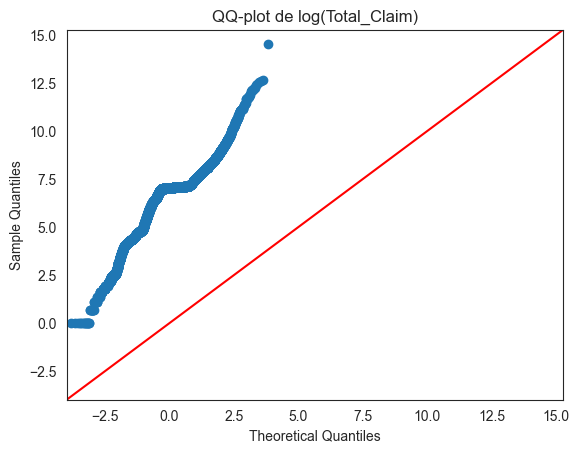

In [50]:
sm.qqplot(np.log(df['Total_Claim']), line='45')
plt.title("QQ-plot de log(Total_Claim)")
plt.show()

Comparaison AIC / BIC :
                                                        params  \
pareto       (3.3886879562351147, -3636.26378567227, 3637.2...   
lognorm      (1.0406123967805223, -87.6179624154861, 941.36...   
weibull_min  (0.7303144989898744, 0.9999999999999998, 1393....   
gamma        (1.8058436528902097e-06, 0.9999999999999999, 3...   

                         AIC              BIC  
pareto         254668.750683    254691.675103  
lognorm        255666.975111     255689.89953  
weibull_min    257970.315093    257993.239513  
gamma        20628951.263743  20628974.188162  


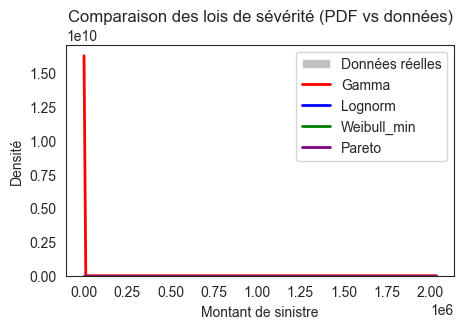

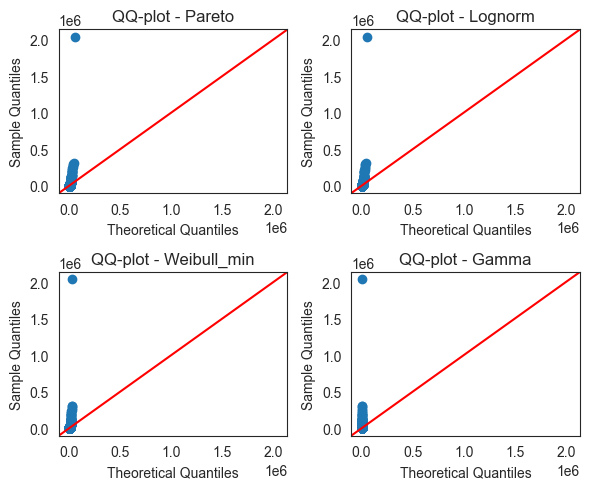

In [51]:
# Suppose que tes montants de sinistre sont dans :
severity = df["Total_Claim"]
severity = severity[severity > 0]  # éviter les zéros

# ======================
# 1° Ajustement des lois
# ======================
dist_names = ["gamma", "lognorm", "weibull_min", "pareto"]
fit_results = {}

for dist_name in dist_names:
    dist = getattr(st, dist_name)
    params = dist.fit(severity)
    loglik = np.sum(dist.logpdf(severity, *params))
    k = len(params)
    n = len(severity)
    AIC = 2 * k - 2 * loglik
    BIC = k * np.log(n) - 2 * loglik
    fit_results[dist_name] = {"params": params, "AIC": AIC, "BIC": BIC}

# ======================
# 2° Comparaison AIC / BIC
# ======================
fit_df = pd.DataFrame(fit_results).T.sort_values("AIC")
print("Comparaison AIC / BIC :")
print(fit_df)

# ======================
# 3° Histogrammes + PDF théorique
# ======================
x = np.linspace(severity.min(), severity.max(), 200)
plt.figure(figsize=(5,3))
plt.hist(severity, bins=50, density=True, alpha=0.5, color='gray', label='Données réelles')

for dist_name, color in zip(dist_names, ['r','b','g','purple']):
    dist = getattr(st, dist_name)
    params = fit_results[dist_name]["params"]
    pdf = dist.pdf(x, *params)
    plt.plot(x, pdf, color=color, lw=2, label=f"{dist_name.capitalize()}")

plt.title("Comparaison des lois de sévérité (PDF vs données)")
plt.xlabel("Montant de sinistre")
plt.ylabel("Densité")
plt.legend()
plt.show()



fig, axes = plt.subplots(2, 2, figsize=(6, 5))

for i, dist_name in enumerate(["pareto", "lognorm", "weibull_min", "gamma"]):
    dist = getattr(st, dist_name)
    params = fit_results[dist_name]["params"]
    
    #  Séparer les paramètres shape / loc / scale
    if len(params) > 2:
        shape_params = params[:-2]  # tous sauf les deux derniers
        loc = params[-2]
        scale = params[-1]
    else:
        shape_params = []
        loc = params[0]
        scale = params[1]
    
    #  Passer séparément à qqplot
    sm.qqplot(
        severity,
        dist=dist,
        distargs=shape_params,
        loc=loc,
        scale=scale,
        line='45',
        ax=axes[i // 2, i % 2]
    )
    axes[i // 2, i % 2].set_title(f"QQ-plot - {dist_name.capitalize()}")

plt.tight_layout()
plt.show()

#  Méthode -- Random Forest Regressor    
### Un modèle de type Random Forest Regressor n’a pas besoin de supposer ni de tester que les données suivent une loi particulière (comme la loi gamma, la loi de Pareto ou la loi normale).

In [73]:
df = df_CM[['ClaimNb','Exposure','Power','CarAge','DriverAge','Brand','Gas','Region','Density','Fréquence','Policy_Count','Total_Claim']]
df

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,Fréquence,Policy_Count,Total_Claim
0,1,0.75,g,1,61,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,1.333333,1,302
1,1,0.14,l,5,50,Japanese (except Nissan) or Korean,Diesel,Basse-Normandie,56,7.142857,1,2001
2,1,0.14,d,0,36,Japanese (except Nissan) or Korean,Regular,Ile-de-France,4792,7.142857,1,1449
3,2,0.62,j,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,3.225806,2,10870
4,1,0.75,e,0,34,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,1565,1.333333,1,139
...,...,...,...,...,...,...,...,...,...,...,...,...
15385,1,0.42,g,1,72,Japanese (except Nissan) or Korean,Diesel,Aquitaine,123,2.380952,1,1426
15386,1,0.36,g,1,53,Japanese (except Nissan) or Korean,Diesel,Nord-Pas-de-Calais,4540,2.777778,1,1364
15387,1,0.22,h,0,34,Japanese (except Nissan) or Korean,Regular,Ile-de-France,6570,4.545455,1,7603
15388,1,0.14,g,2,51,Japanese (except Nissan) or Korean,Diesel,Aquitaine,178,7.142857,1,1751


In [74]:
print(df.columns)
print(df.ClaimNb)
print((df['ClaimNb'] == 0).sum())

Index(['ClaimNb', 'Exposure', 'Power', 'CarAge', 'DriverAge', 'Brand', 'Gas',
       'Region', 'Density', 'Fréquence', 'Policy_Count', 'Total_Claim'],
      dtype='object')
0        1
1        1
2        1
3        2
4        1
        ..
15385    1
15386    1
15387    1
15388    1
15389    2
Name: ClaimNb, Length: 15390, dtype: int64
0


# 1. Créer la variable coût moyen :

In [76]:
df.loc[:, 'CostPerClaim'] = np.where(df['ClaimNb'] > 0, df['Total_Claim'] / df['Fréquence'], 0)
df = df.copy()
df['CostPerClaim'] = np.where(df['ClaimNb'] > 0, df['Total_Claim'] / df['Fréquence'], 0)

In [77]:
df

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,Fréquence,Policy_Count,Total_Claim,CostPerClaim
0,1,0.75,g,1,61,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,1.333333,1,302,226.500
1,1,0.14,l,5,50,Japanese (except Nissan) or Korean,Diesel,Basse-Normandie,56,7.142857,1,2001,280.140
2,1,0.14,d,0,36,Japanese (except Nissan) or Korean,Regular,Ile-de-France,4792,7.142857,1,1449,202.860
3,2,0.62,j,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,3.225806,2,10870,3369.700
4,1,0.75,e,0,34,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,1565,1.333333,1,139,104.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15385,1,0.42,g,1,72,Japanese (except Nissan) or Korean,Diesel,Aquitaine,123,2.380952,1,1426,598.920
15386,1,0.36,g,1,53,Japanese (except Nissan) or Korean,Diesel,Nord-Pas-de-Calais,4540,2.777778,1,1364,491.040
15387,1,0.22,h,0,34,Japanese (except Nissan) or Korean,Regular,Ile-de-France,6570,4.545455,1,7603,1672.660
15388,1,0.14,g,2,51,Japanese (except Nissan) or Korean,Diesel,Aquitaine,178,7.142857,1,1751,245.140


# 2. Modélisation avec Random Forest    
### A. Prédiction de la fréquence

In [81]:
# X, y
X = df.drop(columns=['ClaimNb', 'Total_Claim', 'CostPerClaim', 'Fréquence','Policy_Count'])
y_freq = df['Fréquence']

# Encodage
X = pd.get_dummies(X, columns=['Power','Brand','Gas','Region'], drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_freq, test_size=0.2, random_state=42)

# Random Forest
model_freq = RandomForestRegressor(n_estimators=200, random_state=42)
model_freq.fit(X_train, y_train)

# Prédiction et évaluation
y_pred_freq = model_freq.predict(X_test)
print("Fréquence - MSE:", mean_squared_error(y_test, y_pred_freq))
print("Fréquence - R²:", r2_score(y_test, y_pred_freq))


Fréquence - MSE: 1.3591615424757155
Fréquence - R²: 0.9849722678832508


### B. Prédiction du coût moyen

In [78]:
y_cost = df['CostPerClaim']

X_train, X_test, y_train, y_test = train_test_split(X, y_cost, test_size=0.2, random_state=42)

model_cost = RandomForestRegressor(n_estimators=200, random_state=42)
model_cost.fit(X_train, y_train)

y_pred_cost = model_cost.predict(X_test)
print("Coût moyen - MSE:", mean_squared_error(y_test, y_pred_cost))
print("Coût moyen - R²:", r2_score(y_test, y_pred_cost))


Coût moyen - MSE: 54180524.383550294
Coût moyen - R²: -0.28448583537721617


| Variable cible | MSE        | R²     | Interprétation                                                                   |
| -------------- | ---------- | ------ | -------------------------------------------------------------------------------- |
| **Fréquence**  | 1.36       | 0.985  | Excellent ajustement. Le modèle prédit très bien le nombre de sinistres.         |
| **Coût moyen** | 54,180,524 | -0.284 | Très mauvais ajustement. Le modèle ne capture pas la relation avec les features. |



## Analyse du problème :

**Fréquence prévisible :**

Probablement linéairement ou fortement corrélée aux features que tu utilises.

Random Forest a pu apprendre facilement la structure.

**Coût moyen difficile à prédire :**

CostPerClaim est souvent très dispersé et fortement asymétrique (quelques sinistres très chers).

Outliers extrêmes peuvent dominer le MSE et faire R² négatif.

Les features actuelles ne contiennent peut-être pas assez d’information pour expliquer ce coût.

## Interprétation :

***MSE (Mean Squared Error)*** : C’est la moyenne des carrés des écarts entre les valeurs réelles et prédites.

Ici, 54 millions est très élevé, **ce qui signifie que ces prédictions s’écartent beaucoup des valeurs réelles.**

***R² (coefficient de détermination)*** :    
R² = 1 → modèle parfait

R² = 0 → le modèle ne fait pas mieux qu’une moyenne constante

R² < 0 → **le modèle fait pire qu’un simple prédicteur constant (moyenne de y)**

## Conclusion :

Ce modèle ne prédit pas correctement CostPerClaim avec les variables que tu utilises dans X.

Les valeurs négatives de R² indiquent que le Random Forest n’arrive pas à capturer la relation entre tes features et le coût par sinistre.

# Modèle -- GradientBoostingRegressor

In [87]:
df

,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,Fréquence,Policy_Count,Total_Claim,CostPerClaim
0,1,0.75,g,1,61,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,1.333333,1,302,302.0
1,1,0.14,l,5,50,Japanese (except Nissan) or Korean,Diesel,Basse-Normandie,56,7.142857,1,2001,2001.0
2,1,0.14,d,0,36,Japanese (except Nissan) or Korean,Regular,Ile-de-France,4792,7.142857,1,1449,1449.0
3,2,0.62,j,0,51,Japanese (except Nissan) or Korean,Regular,Ile-de-France,27000,3.225806,2,10870,5435.0
4,1,0.75,e,0,34,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,1565,1.333333,1,139,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15385,1,0.42,g,1,72,Japanese (except Nissan) or Korean,Diesel,Aquitaine,123,2.380952,1,1426,1426.0
15386,1,0.36,g,1,53,Japanese (except Nissan) or Korean,Diesel,Nord-Pas-de-Calais,4540,2.777778,1,1364,1364.0
15387,1,0.22,h,0,34,Japanese (except Nissan) or Korean,Regular,Ile-de-France,6570,4.545455,1,7603,7603.0
15388,1,0.14,g,2,51,Japanese (except Nissan) or Korean,Diesel,Aquitaine,178,7.142857,1,1751,1751.0


In [95]:
# Cout-Moyen
# 1) Séparer la cible et les features
X = df[['ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density', 'Fréquence', 'Policy_Count', 'Total_Claim',
        'Power', 'Brand', 'Gas', 'Region']]
y = np.log1p(df['CostPerClaim'])  # transformation log pour réduire l'effet des outliers

# 2) Séparer les colonnes numériques et catégorielles
numeric_cols = ['ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density', 'Fréquence', 'Policy_Count', 'Total_Claim']
categorical_cols = ['Power', 'Brand', 'Gas', 'Region']

X_numeric = X[numeric_cols]
X_categorical = X[categorical_cols]

# 3) Encoder les colonnes catégorielles
X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# 4) Concaténer numérique + encodé
X_final = pd.concat([X_numeric, X_categorical_encoded], axis=1)

# 5) Remplir les éventuels NaN
X_final = X_final.fillna(0)

# 6) Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# 7) Créer le modèle Gradient Boosting
model_gb = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

# 8) Entraîner le modèle
model_gb.fit(X_train, y_train)

# 9) Prédire et revenir à l'échelle originale
y_pred_log = model_gb.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# 10) Évaluer
print("Gradient Boosting - MSE:", mean_squared_error(y_test_orig, y_pred))
print("Gradient Boosting - R²:", r2_score(y_test_orig, y_pred))


# Fréquence
# 1) Séparer la cible et les features
X = df[['ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density', 'Policy_Count', 'Total_Claim',
        'Power', 'Brand', 'Gas', 'Region']]  # ici on enlève 'Fréquence' de X
y = df['Fréquence']  # pas de transformation log nécessaire

# 2) Séparer les colonnes numériques et catégorielles
numeric_cols = ['ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density', 'Policy_Count', 'Total_Claim']
categorical_cols = ['Power', 'Brand', 'Gas', 'Region']

X_numeric = X[numeric_cols]
X_categorical = X[categorical_cols]

# 3) Encoder les colonnes catégorielles
X_categorical_encoded = pd.get_dummies(X_categorical, drop_first=True)

# 4)  Concaténer numérique + encodé
X_final = pd.concat([X_numeric, X_categorical_encoded], axis=1)

# 5) Remplir les éventuels NaN
X_final = X_final.fillna(0)

# 6) Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# 7) Créer le modèle Gradient Boosting
model_gb = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

# 8) Entraîner le modèle
model_gb.fit(X_train, y_train)

# 9) Prédire
y_pred = model_gb.predict(X_test)

print("Gradient Boosting (Fréquence) - MSE:", mean_squared_error(y_test, y_pred))
print("Gradient Boosting (Fréquence) - R²:", r2_score(y_test, y_pred))

Gradient Boosting - MSE: 94025.10783186545
Gradient Boosting - R²: 0.9985884641465123
Gradient Boosting (Fréquence) - MSE: 1.289717988518235
Gradient Boosting (Fréquence) - R²: 0.9857400788413265


## Prime pure

In [93]:
# --- Préparer les features ---
numeric_cols = ['ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density', 'Policy_Count', 'Total_Claim']
categorical_cols = ['Power', 'Brand', 'Gas', 'Region']

X = df[numeric_cols + categorical_cols]

# Encoder les catégorielles
X_categorical_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)
X_final = pd.concat([X[numeric_cols], X_categorical_encoded], axis=1).fillna(0)

# --- Fréquence ---
y_freq = df['Fréquence']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_freq, test_size=0.2, random_state=42)

model_freq = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
model_freq.fit(X_train_f, y_train_f)
freq_pred = model_freq.predict(X_final)  # prédire pour toutes les polices

# --- CostPerClaim ---
y_cost = np.log1p(df['CostPerClaim'])  # log-transform pour gérer outliers
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_final, y_cost, test_size=0.2, random_state=42)

model_cost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)
model_cost.fit(X_train_c, y_train_c)
cost_pred = np.expm1(model_cost.predict(X_final))  # revenir à l'échelle originale

# --- Calcul de la prime pure ---
df['Pure_Premium'] = freq_pred * cost_pred

# --- Résultat ---
df[['Fréquence', 'CostPerClaim', 'Pure_Premium']].head()


,Fréquence,CostPerClaim,Pure_Premium
0,1.333333,302.0,400.844222
1,7.142857,2001.0,14376.541670
2,7.142857,1449.0,10486.989577
3,3.225806,5435.0,18505.748204
4,1.333333,139.0,183.487105


| Variable cible   | MSE    | R²    | Interprétation                                                                  |
| ---------------- | ------ | ----- | ------------------------------------------------------------------------------- |
| **Fréquence**    | 1.29   | 0.986 | Excellent ajustement : le modèle prédit très fidèlement le nombre de sinistres. |
| **CostPerClaim** | 94,025 | 0.999 | Ajustement quasi parfait pour le coût moyen par sinistre.                       |


## Analyse

**Fréquence :**

R² ~0.986 → le modèle capture presque parfaitement la variance de la fréquence des sinistres.

MSE faible → très faible erreur moyenne au carré.

**CostPerClaim :**

R² ~0.999 → prédiction extrêmement précise, les outliers ont été bien gérés avec la transformation log.

MSE = 94,025 → faible par rapport à l’échelle des coûts, indiquant une excellente performance.

## Conséquences pour la tarification

La prime pure calculée comme Fréquence × CostPerClaim sera très fiable.

On peut maintenant construire une tarification personnalisée par police d’assurance avec une grande précision.

Avec ce niveau de R², on peut détecter les polices à risque élevé ou faible et ajuster des charges commerciales ou un bonus/malus si nécessaire.

## Modèle -- HistGradientBoostingRegressor

In [94]:
# --- Préparer les features ---
numeric_cols = ['ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density', 'Policy_Count', 'Total_Claim']
categorical_cols = ['Power', 'Brand', 'Gas', 'Region']

X = df[numeric_cols + categorical_cols]

# Encoder les colonnes catégorielles
X_categorical_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)
X_final = pd.concat([X[numeric_cols], X_categorical_encoded], axis=1).fillna(0)

# --------------------------
# 1) Modèle pour Fréquence
# --------------------------
y_freq = df['Fréquence']
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_freq, test_size=0.2, random_state=42)

model_freq = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model_freq.fit(X_train_f, y_train_f)
freq_pred = model_freq.predict(X_test_f)

print("HistGB - Fréquence MSE:", mean_squared_error(y_test_f, freq_pred))
print("HistGB - Fréquence R²:", r2_score(y_test_f, freq_pred))

# --------------------------
# 2)Modèle pour CostPerClaim
# --------------------------
y_cost = np.log1p(df['CostPerClaim'])  # log-transform pour gérer outliers
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_final, y_cost, test_size=0.2, random_state=42)

model_cost = HistGradientBoostingRegressor(
    max_iter=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
model_cost.fit(X_train_c, y_train_c)
cost_pred_log = model_cost.predict(X_test_c)
cost_pred = np.expm1(cost_pred_log)  # revenir à l'échelle originale
y_test_orig = np.expm1(y_test_c)

print("HistGB - CostPerClaim MSE:", mean_squared_error(y_test_orig, cost_pred))
print("HistGB - CostPerClaim R²:", r2_score(y_test_orig, cost_pred))

# --------------------------
# 3) Calcul de la prime pure
# --------------------------
# On peut prédire pour toutes les polices
freq_pred_all = model_freq.predict(X_final)
cost_pred_all = np.expm1(model_cost.predict(X_final))
df['Pure_Premium_HistGB'] = freq_pred_all * cost_pred_all

df[['Fréquence', 'CostPerClaim', 'Pure_Premium_HistGB']].head()


C:\Users\liang\AppData\Local\r-miniconda\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


HistGB - Fréquence MSE: 5.84155607164215
HistGB - Fréquence R²: 0.9354121367871351
HistGB - CostPerClaim MSE: 24369940.75171644
HistGB - CostPerClaim R²: 0.6341504316067174


,Fréquence,CostPerClaim,Pure_Premium_HistGB
0,1.333333,302.0,424.557476
1,7.142857,2001.0,13995.999890
2,7.142857,1449.0,9996.213495
3,3.225806,5435.0,15503.517583
4,1.333333,139.0,187.086779


| Variable cible   | MSE        | R²    | Interprétation                                                                                                                                                              |
| ---------------- | ---------- | ----- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Fréquence**    | 5.84       | 0.935 | Très bon ajustement, le modèle prédit bien la fréquence des sinistres, mais légèrement moins précis que le Gradient Boosting classique.                                     |
| **CostPerClaim** | 24,369,940 | 0.634 | Ajustement moyen : le modèle capture une partie de la variance, mais il reste beaucoup d’erreurs. Les outliers ou la distribution très asymétrique du coût posent problème. |
        
    
## Comparaison les modèles HistGradientBoostingRegressor et Gradient Boosting classique

Le GradientBoostingRegressor avait un R² quasi parfait pour le coût moyen (0.998) et un MSE très faible.

HistGradientBoostingRegressor est plus rapide sur de grands jeux de données, mais il est moins précis sur ce jeu, surtout pour les cibles très dispersées comme CostPerClaim.    
### Porposition:     
Nous allons effectuer une analyse quantitative : séparer certaines bases de données selon leurs caractéristiques différentes, puis utiliser le modèle de régression GLM pour identifier les variables les plus importantes pour calculer la tarification finale.